# Mining Unexpected Concepts
---
Wikivitals

**Libraries**

In [317]:
from collections import defaultdict, Counter
from contextlib import redirect_stdout
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import random
import seaborn as sns
from scipy import sparse, special

from sknetwork.data import load_netset, from_edge_list
from sknetwork.utils import get_degrees, get_membership, get_neighbors
from sknetwork.ranking import top_k
from sknetwork.topology import Triangles, Cliques
from sknetwork.visualization import svg_graph

## Data

In [2]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [3]:
adjacency = wikivitals.adjacency
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

In [4]:
names

array(['0', '1', '100 metres', ..., 'Łódź', 'Śāriputra', '−1'],
      dtype='<U62')

In [5]:
words[:10]

array(['Alexis', 'Cairo', 'subordinate', 'marching', 'bengali', 'Adal',
       'pulvinus', 'Gallia', 'Harris', 'Toshiro'], dtype='<U26')

## Algorithm

In [324]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')
    
def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    #d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    return (nodes_mdl + edges_mdl)

def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr

In [282]:
def in_close(adjacency, context, extents, intents, unexs, unexs_g, r, y, degs, gain, verbose):
    
    support_obj = 5
    support_attr = 15
    delta = 5
    
    global gain_unex
    # --------------------
    
    global r_new
    r_new = r_new + 1
    attributes = np.arange(0, context.shape[1])
    
    for n_iter, j in enumerate(attributes[y:]):
        
        try:
            extents[r_new] = []
            unexs[r_new] = 0
            unexs_g[r_new] = 0
        except IndexError:
            extents.append([])
            unexs.append(0)
            unexs_g.append(0)

        # Form a new extent by adding extension of attribute j to current concept extent
        extension_j = get_neighbors(context, node=j, transpose=True)
        new_extent = np.array(list(set(extents[r]).intersection(set(extension_j))))
        extents[r_new] = new_extent
        new_extent_size = len(new_extent)
        
        # Verify that intention
        len_closure = 0
        if len(new_extent > 0):
            all_neighbs = set(get_neighbors(context, node=new_extent[0]))
            for o in new_extent[1:]:
                neighbs = get_neighbors(context, node=o)
                all_neighbs &= set(neighbs)
            len_closure = len(all_neighbs)
        
            
        if len_closure >= support_obj:
            #if verbose:
            #    print(f'closure of {new_extent} --> size of closure = {len_closure}>{support_obj}')
            
            
            if new_extent_size >= support_obj:
                if verbose:
                    print(f'n_iter:{n_iter} - extents: {extents[r]} - intents: {intents[r]}')
                    print(f'  Candidate attr: {j} {sorted_names_col[j]}')
                    print(f'  new extent: {new_extent}')

                #if new_extent_size < len(extents[r]):
                # Graph unexpectedness
                g_r_new = adjacency[new_extent][:, new_extent]
                complexity_desc_g = mdl_graph(g_r_new)
                complexity_gen_g = np.mean(complexity_gen_graphs.get(new_extent_size))
                unex_g = complexity_gen_g - complexity_desc_g
                unexs_g.append(unex_g)
                if verbose:
                    print(f'  U(G)={unex_g} (cw={complexity_gen_g} - c={complexity_desc_g})')

                new_intent = np.array(list(sorted(set(intents[r]).union(set([j])))))
                new_intent_size = len(new_intent)            

                if new_intent_size <= support_attr:

                    # Attributes unexpectedness
                    complexity_gen_a = np.log2(special.comb(context.shape[1], new_intent_size))
                    complexity_desc_a = 0
                    for a in new_intent:
                        complexity_desc_a += np.log2(degs[a])
                    unex_a = complexity_gen_a - complexity_desc_a
                    if verbose:
                        print(f'  U(A)={unex_a} (cw={complexity_gen_a} - c={complexity_desc_a})')

                    # Total Unexpectedness
                    unex = unex_g + unex_a
                    if verbose:
                        print(f'  U: {unex}')
                    unexs[r_new] = unex

                    if verbose:
                        print(f'  U[r_new]={unex} - U[r]={unexs[r]}  = {unex - unexs[r]}')

                    gain_unex.append(unex - unexs[r])
                    if verbose:
                        print(f'  gain unex: {gain_unex}')
                        print(f'  Gain unex diff: {np.abs(gain_unex[-2]-gain_unex[-1])}')

                    if new_extent_size == len(extents[r]):

                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        if (len(intents[r]) == 0) or ((unex - unexs[r] > 0) and (np.abs(gain_unex[-2] - gain_unex[-1])) > delta):
                            intents[r] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                            extents[r] = extents[r_new]
                            unexs_g[r] = unex_g
                            unexs[r] = unex
                            if verbose:
                                print(f'  Attribute {j}-{sorted_names_col[j]} added')
                        else:
                            if verbose:
                                print(f'  unex - unexs[r] > 0 : {(unex - unexs[r] > 0)}')
                                print(f'  (gain_unex[-2] - gain_unex[-1]) > delta : {(gain_unex[-2] - gain_unex[-1]) > delta}')
                                print(f'  len(intents[r]) == 0 : {len(intents[r]) == 0}')
                                print(f'  --> Stop branch recursion. ')
                                print('\n')

                            #del gain_unex[(r_new-r):]
                                if len(intents[r]) > 1:
                                    del gain_unex[-(len(intents[r]))+1:]
                                else:
                                    del gain_unex[-(len(intents[r])):]

                            return [*zip(extents, intents)]

                    else:
                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        if (len(intents[r]) == 0) or (unex - unexs[r] > 0):

                            try:
                                intents[r_new] = []
                            except IndexError:
                                intents.append([])

                            intents[r_new] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                            if verbose:
                                print('  recursive call')
                            in_close(adjacency, context, extents, intents, unexs, unexs_g, r=r_new, y=j+1, degs=degs, gain=gain_unex, verbose=verbose)
                        else:
                            if verbose:
                                print(f'  Do not go into recursion. Try next candidate attribute. ')
                                print()
                            gain_unex.pop(-1)
                else:
                    if verbose:
                        print(f'Max number of attributes reached.')
                        print('\n')
                    return [*zip(extents, intents)]

            #else:
            #    if verbose:
            #        print(f'  New extent size >= support? : {new_extent_size >= support_obj}')
            
        #else:
            #if verbose:
                #    print(f'closure of {new_extent} --> no need to verify all attributes')
    if verbose:
        print('\n')
        

    if len(intents[r]) > 1:
        del gain_unex[-(len(intents[r]))+1:]
    else:
        del gain_unex[-(len(intents[r])):]
    return [*zip(extents, intents)]

## Application

### Minimum Description Lengths of random graphs  

Build a dictionary of MDL for random graphs with varying number of nodes and density.

In [8]:
# Density of initial graph
n, m = adjacency.shape[0], adjacency.nnz
density = (m) / (n * (n - 1))
density

0.008232692290229

In [162]:
%%time
complexity_gen_graphs = defaultdict(list)

for num_n in range(adjacency.shape[0] + 1)[3:1000]:
    cpt = 0
    while cpt < 3:
        random_g = sparse.random(num_n, num_n, density=0.5).astype(bool).tocsr()
        if random_g is not None and random_g.shape[0] == num_n:
            mdl = mdl_graph(random_g)
            complexity_gen_graphs[num_n].append(mdl)
            cpt += 1

CPU times: user 1min 39s, sys: 2.73 s, total: 1min 42s
Wall time: 1min 42s


In [163]:
#import pickle
#f = open("complexity_gen_graphs.pkl", "wb")
#pickle.dump(complexity_gen_graphs, f)
#f.close()

In [283]:
# In-close initialization
V = np.arange(0, biadjacency.shape[0])
extents, intents, unexs, unexs_g = [], [], [], []
extents_init = V
intents_init = []
unexs.append(0)
unexs_g.append(0)
extents.append(extents_init)
intents.append(intents_init)

In [284]:
global r_new
r_new = 0
global gain_unex
gain_unex = []
gain_unex.append(0)

n_objects_min = 5
n_objects_max = 999

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
sort_index = np.argsort(freq_attribute)
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

In [285]:
%%time

with open('logs/log_wikivitals.txt', 'w') as f:
    with redirect_stdout(f):
        result = in_close(adjacency, filt_biadjacency, extents, intents, unexs, unexs_g, r=0, y=0, degs=sorted_degs, gain=gain_unex, verbose=True)
        print()

CPU times: user 1h 19min 35s, sys: 13min 45s, total: 1h 33min 20s
Wall time: 1h 50min 18s


In [306]:
# Save result
with open("result/result.bin", "wb") as output:
    pickle.dump(result, output)

In [307]:
# Load result
#with open("result/result.bin", "rb") as data:
#    myList = pickle.load(data)

In [288]:
print(len(result))
print(type(result))

350
<class 'list'>


In [297]:
print(f'Attributes | Nodes')
rand_idx = np.random.choice(len(result), 10)
for i in rand_idx:
    concepts = result[i]
    print(f'{str(concepts[1]):<25} {concepts[0]}')

Attributes | Nodes
[ 3232  4409 16476]       [2471 5418 3436 3543  893]
[ 5153 11599 14900]       [3397 2950 1357 4536 9150]
[ 5327 15777]             [5893 7847 5360 4948 2964 9685]
[3983 7224 8801]          [7745 8578 8740 7500 8914 5652]
[ 2306 14951]             [5448  877 4081 6196 9720]
[3539 5486]               [9572 7847 3403 2486 8155]
[ 5429 17017]             [9094 4166 1576 6317 9938 8921 7900 5183]
[ 6054 12660]             [5889 5538 9804 5233 4948]
[1605]                    [1793 4905 3276 2065 5913]
[3820 7486]               [9965  557  432 3985  722]


**Nodes and attributes size distributions in concepts**

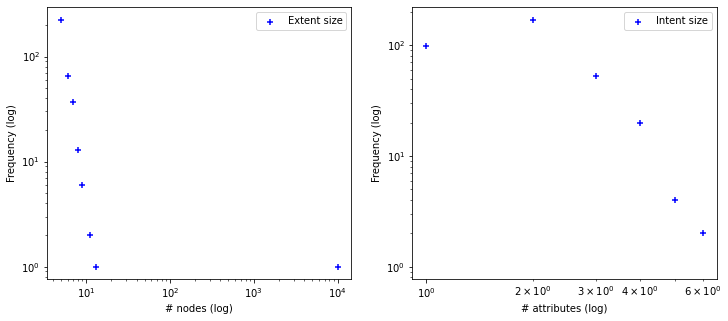

In [334]:
nodes_list, attrs_list = zip(*result)

len_n = map(len, nodes_list)
len_a = map(len, attrs_list)

fig, ax = plt.subplots(1, 2, figsize=(12, 5),)
plot_distrib(Counter(len_n), ax[0], label='Extent size', xlabel='# nodes')
plot_distrib(Counter(len_a), ax[1], label='Intent size', xlabel='# attributes')

['Dolly' 'hello' 'singer']


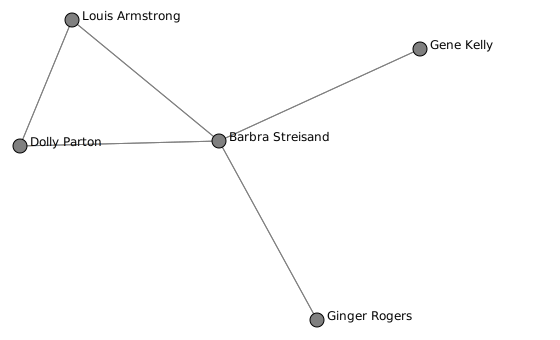

In [298]:
# First graph
objs = np.array([2471, 5418, 3436, 3543,  893])
attrs = np.array([3232, 4409, 16476])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['monazite' 'earth']


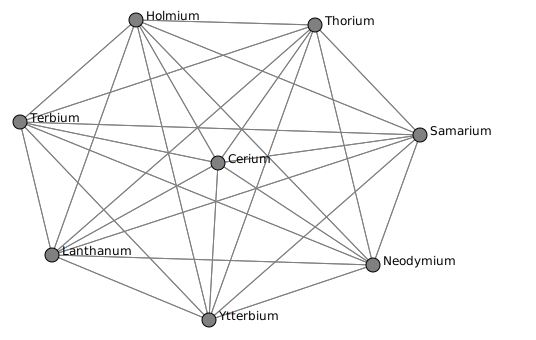

In [299]:
# First graph
objs = np.array([9094, 4166, 1576, 6317, 9938, 8921, 7900, 5183])
attrs = np.array([5429, 17017])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['Anschluss' 'Hitler']


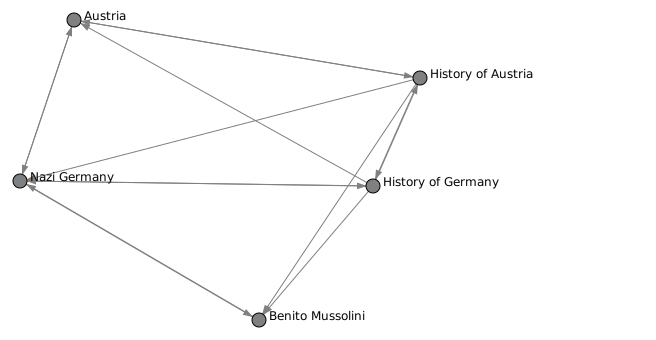

In [347]:
# First graph
objs = np.array([777, 4078, 1010, 6298, 4063])
attrs = np.array([103, 14319])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['Civilis']


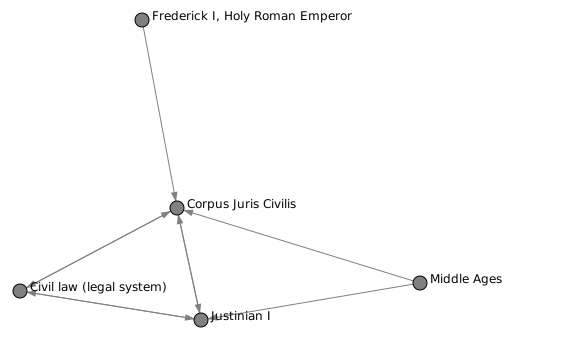

In [348]:
objs = np.array([1793, 4905, 3276, 2065, 5913])
attrs = np.array([1605])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

## Annexes
---

In [ ]:
def build_random_graph(n, p):
    edges = []
    lp = np.log(1 - p)
    v = 1
    w = -1
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((w, v))
    
    v = 1
    w = -1   
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((v, w))
    try:
        g = from_edge_list(edges, directed=True, matrix_only=True)
    except ValueError:
        return None

    return g